UCEC Reccurance Notebook

Importing data from ucec_tcga_pan_can_atlas_2018

In [29]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier  # one model I'm just going to try first
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

from collections import Counter
import matplotlib.pyplot as plt


In [20]:
mrna_df = pd.read_csv("ucec_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt", sep="\t", comment="#")
# I appear to have 527 patients in the mRNA and 529 patients in the clinical data

clinical_df = pd.read_csv("ucec_tcga_pan_can_atlas_2018\data_clinical_patient.txt", sep="\t", comment="#", low_memory=False)
clinical_df = clinical_df.set_index('PATIENT_ID')

# The first 2 columns of the mRNA data are labels. 13 of the genes do not have Hugo_symbols, so I am putting placeholder stings as labels for these genes
missing_symbols = mrna_df['Hugo_Symbol'].isnull()
mrna_df.loc[missing_symbols, 'Hugo_Symbol'] = [
    f'no_symbol_{i+1}' for i in range(missing_symbols.sum())
]

# Get value counts
counts = mrna_df['Hugo_Symbol'].value_counts()

# Generate unique labels for duplicates
def label_duplicates(value, index):
    if counts[value] == 1:
        return value  # Keep unique values unchanged
    occurrence = mrna_df.groupby('Hugo_Symbol').cumcount() + 1  # Count occurrences per group
    return f"{value}-{occurrence[index]}-of-{counts[value]}"

# Apply the labeling function
mrna_df['Hugo_Symbol'] = [label_duplicates(value, idx) for idx, value in mrna_df['Hugo_Symbol'].items()]

mrna_df = mrna_df.set_index('Hugo_Symbol')
mrna_df = mrna_df.drop(columns="Entrez_Gene_Id") # removing the label column before I transpose the df
mrna_df_transposed= mrna_df.transpose()
mrna_df_transposed.index = [id[:-3] for id in mrna_df_transposed.index] # removes extranious -01 so that the patient ids match the clinical data

df = clinical_df.join(mrna_df_transposed, how='inner') # this is the data frame for clinical and genetic data. It has 527 patients (rows) and 20568 features (columns).

The following genes appear in the data more than once but have different data: 
['PALM2AKAP2', 'ELMOD1', 'FGF13', 'QSOX1', 'SNAP47', 'NKAIN3', 'TMEM8B']
Right now, I'm leaving every version of the gene in, but giving placeholder unique names like: PALM2AKAP2-1-of-2 and PALM2AKAP2-2-of-2

Removing unecessary columns from clinical data.

In [ ]:
MAX_NULL_VALS = 0.3

def assign_label(row):
    '''given a row assigns 1 for recurrance and 0 for no recurrance. 
    Currently uses NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT to identify recurrance.
    If NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT is NaN, uses DSF_STATUS'''
    if row['NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT'] == 'Yes':
        return 1
    elif row['NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT'] == 'No':
        return 0
    elif pd.isna(row['NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT']):
        if row['DFS_STATUS'] == '1:Recurred/Progressed':
            return 1
        elif row['DFS_STATUS'] == '0:DiseaseFree':
            return 0
        else:
            raise ValueError(f"Error: Both columns are NaN at index {row.name}")

for col in df.columns:
    unique_values = df[col].nunique(dropna=True)
    if unique_values <= 1:
        # print(f"Removing column: {col}")
        df.drop(columns=[col], inplace=True)

# remove the column is over MAX_NULL_VALS percent null values
df.dropna(axis=1, thresh=len(df) * (1 - MAX_NULL_VALS))

# remove non-informational columns
df = df.drop(columns=['OTHER_PATIENT_ID'])

pair_counts = df.groupby(["NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT", 'DFS_STATUS'], dropna=False).size().reset_index(name='Count')

# Print the pairings and the count
print(pair_counts)

# I am going to remove the 32 rows where we have no recurrance label (neither NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT nor DFS_STATUS are known)
# PFS_STATUS
df = df.dropna(subset=['DFS_STATUS', 'NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT'], how='all')

# # numpy array for the Labels for recurrance
labels = np.array(df.apply(assign_label, axis=1)) 
#DIF DFI.time 

  NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT             DFS_STATUS  Count
0                                      No          0:DiseaseFree    326
1                                      No  1:Recurred/Progressed     12
2                                      No                    NaN     49
3                                     Yes          0:DiseaseFree      7
4                                     Yes  1:Recurred/Progressed     38
5                                     Yes                    NaN     34
6                                     NaN          0:DiseaseFree     24
7                                     NaN  1:Recurred/Progressed      5
8                                     NaN                    NaN     32


Transforms data by changing catagorical data into numerical data and filling in missing data points with medians or modes.

In [22]:
categorical_columns = ["ETHNICITY",
                        "ICD_10", 
                        "PRIOR_DX", 
                        "RACE",
                        "RADIATION_THERAPY", 
                        "IN_PANCANPATHWAYS_FREEZE", 
                        "GENETIC_ANCESTRY_LABEL"] #FIXME: do further research on what ICD_10 and ICD_O_3_SITE are

#FIXME: I will need to go through the numerical categories and see if any need to be removed (because they represent data from after initial treatment)
# Fill numerical NaNs with median
numerical_df = df.select_dtypes(include=['number'])
numerical_df = numerical_df.drop(columns=['OS_MONTHS', 'DSS_MONTHS', 'DFS_MONTHS', 'PFS_MONTHS'])
numerical_df = numerical_df.fillna(numerical_df.median())

# fill catagorical columns with mode
categorical_df = df[categorical_columns]
categorical_df = categorical_df.fillna(categorical_df.mode())


# One-Hot Encode categorical columns (drop first to avoid redundancy)
categorical_df = pd.get_dummies(categorical_df, drop_first=True, dtype=float)

X = pd.concat([numerical_df, categorical_df], axis=1)
X = X.to_numpy()


# Part 2: Training My Model

In [26]:
# we should have an X and y now, yay!. Lets do some machine learning 
print("Data shape: ", X.shape)
print("Labels shape: ", labels.shape)


X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Select top 1000 genes most associated with recurrence
selector = SelectKBest(score_func=f_classif, k=1000)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Get indices of selected features (to see which genes they are)
selected_indices = selector.get_support(indices=True)

model = RandomForestClassifier(random_state=100, class_weight='balanced')
# will add a k-fold cross validation, just have random numbers for now
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)  # Ensures balanced class splits

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',  # Change to 'f1', 'roc_auc', etc., if needed
    n_jobs=-1  # Use all CPU cores
)

grid_search.fit(X_selected, y_train)  # Train with cross-validation

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
best_model = grid_search.best_estimator_  # Retrieve the best model

y_test_pred = best_model.predict(X_test)

print(y_test_pred)

cm_test = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm_test.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Compute the AUC-ROC score
roc_auc = roc_auc_score(y_test, y_test_pred)

# Print the AUC-ROC score
print(f"AUC-ROC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)

# Plot the ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.show()



Data shape:  (495, 20044)
Labels shape:  (495,)
[0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 4782  6416  8219  8391  9742 12260 12385 12432 12460 12517 12527 20036] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best Score: 0.7344858058608058


ValueError: X has 20044 features, but RandomForestClassifier is expecting 1000 features as input.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Define pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(score_func=f_classif, k=1000)),
    ('clf', RandomForestClassifier(random_state=100, class_weight='balanced'))
])

# Define hyperparameter grid
param_grid = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 5, 10, 15],
    'clf__min_samples_split': [2, 4]
}

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

# Grid search over pipeline
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',  # Or 'f1' if recurrence class is more important
    n_jobs=-1
)

# Fit pipeline on training data
grid_search.fit(X_train, y_train)
print("Best params:", grid_search.best_params_)

best_model = grid_search.best_estimator_


[0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0
 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1
 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
True Positives (TP): 68
False Positives (FP): 0
True Negatives (TN): 328
False Negatives (FN): 0
AUC-ROC Score: 1.0000


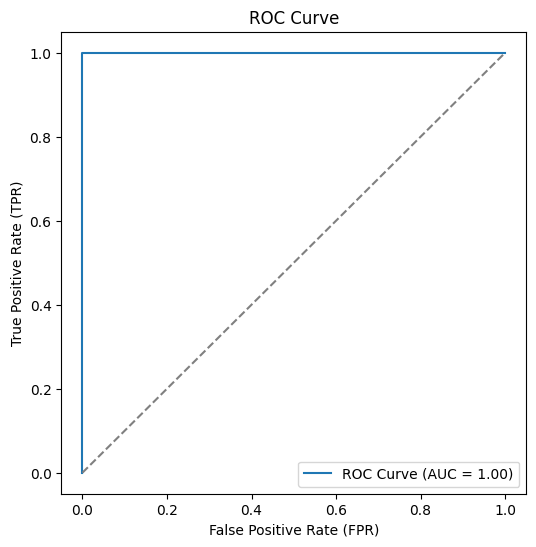

In [36]:
y_train_pred = best_model.predict(X_train)

print(y_train_pred)

cm_test = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = cm_test.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Compute the AUC-ROC score
roc_auc = roc_auc_score(y_train, y_train_pred)

# Print the AUC-ROC score
print(f"AUC-ROC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_train, y_train_pred)

# Plot the ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.show()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
True Positives (TP): 0
False Positives (FP): 0
True Negatives (TN): 83
False Negatives (FN): 16
AUC-ROC Score: 0.5000


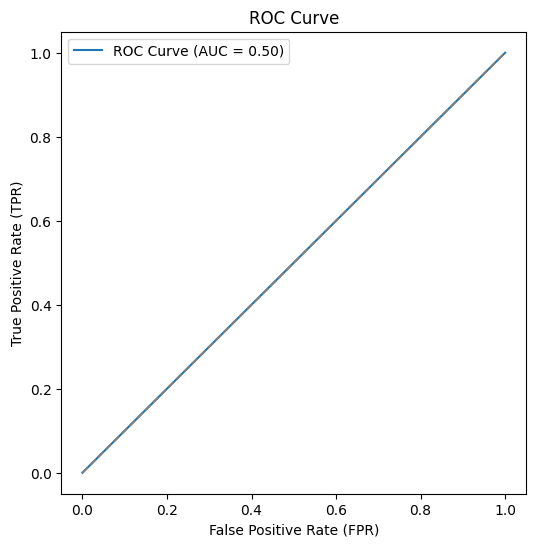

In [32]:
y_test_pred = best_model.predict(X_test)

print(y_test_pred)

cm_test = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm_test.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Compute the AUC-ROC score
roc_auc = roc_auc_score(y_test, y_test_pred)

# Print the AUC-ROC score
print(f"AUC-ROC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)

# Plot the ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.show()